In [3]:
import sparkle
import os
from sparkle import lane
from sparkle import api
from sparkle import circle
from sparkle import gzstats
homedir = os.path.expanduser("~")
import uuid
import glob
import bagpy
from bagpy import bagreader
import pandas as pd
import signal
import  time
import seaborn as sea
import math
import numpy as np
import strym
from strym import strymread

In [4]:
C_init_straight = [0.0, 12.380952381,
24.7619047619,
37.1428571429,
49.5238095238,
61.9047619048,
74.2857142857,
86.6666666667,
99.0476190476,
111.428571429,
123.80952381,
136.19047619,
148.571428571,
160.952380952,
173.333333333,
185.714285714,
198.095238095,
210.476190476,
222.857142857,
235.238095238,
247.619047619]

R = 41.38028520389279

folder = "/home/ivory/CyverseData/ProjectSparkle/RTFvsNVehicles"
bag1 = "sparkle_n_21_update_rate_30.0_max_update_rate_10.0_time_step_0.01_logtime_800.0_2020-10-29-22-53-05.bag"
bag2 = "sparkle_n_21_update_rate_30.0_max_update_rate_10.0_time_step_0.01_logtime_800.0_2020-10-31-15-23-20.bag"
cars = ['magna', 'nebula', 'calista', 'proxima', 'zel',  'zephyr', 'centauri', 'zenith', 'europa', 'elara', 'herse', 'thebe',
                'metis', 'himalia', 'kalyke', 'carpo', 'arche', 'aitne','thyone', 'enceladus','mimas', 'tethys', 'lapetus', 'dione', 'phoebe',
                'epimetheus', 'hyperion', 'rhea', 'telesto', 'deimos', 'phobos', 'triton', 'proteus', 'nereid', 'larissa','galatea', 'despina', 'sirius', 
                'rigel', 'vega', 'altair', 'capella', 'alcor','whirlpool', 'andromeda', 'milkyway',  'cygnus']

In [5]:
df_odom1 = []
b1 = bagreader(folder + '/' + bag1)
for nm in cars:
    setvelfile = b1.message_by_topic('/' + nm + '/odom')
    if setvelfile is None:
        continue
    setvel = pd.read_csv(setvelfile)
    df_odom1.append(setvel)

[INFO]  Data folder /home/ivory/CyverseData/ProjectSparkle/RTFvsNVehicles/sparkle_n_21_update_rate_30.0_max_update_rate_10.0_time_step_0.01_logtime_800.0_2020-10-29-22-53-05 already exists. Not creating.
No data on the topic:/tethys/odom
No data on the topic:/lapetus/odom
No data on the topic:/dione/odom
No data on the topic:/phoebe/odom
No data on the topic:/epimetheus/odom
No data on the topic:/hyperion/odom
No data on the topic:/rhea/odom
No data on the topic:/telesto/odom
No data on the topic:/deimos/odom
No data on the topic:/phobos/odom
No data on the topic:/triton/odom
No data on the topic:/proteus/odom
No data on the topic:/nereid/odom
No data on the topic:/larissa/odom
No data on the topic:/galatea/odom
No data on the topic:/despina/odom
No data on the topic:/sirius/odom
No data on the topic:/rigel/odom
No data on the topic:/vega/odom
No data on the topic:/altair/odom
No data on the topic:/capella/odom
No data on the topic:/alcor/odom
No data on the topic:/whirlpool/odom
No da

In [38]:
b1.topic_table

,Topics,Types,Message Count,Frequency
0,/aitne/cmd_vel,geometry_msgs/Twist,17309,NaN
1,/aitne/odom,nav_msgs/Odometry,9690,100.0
2,/aitne/path,nav_msgs/Path,967,10.0
3,/aitne/setvel,nav_msgs/Odometry,3096,50.0
4,/aitne/vel,geometry_msgs/Twist,3096,50.0
5,/arche/cmd_vel,geometry_msgs/Twist,17309,NaN
6,/arche/odom,nav_msgs/Odometry,9691,100.0
7,/arche/path,nav_msgs/Path,966,10.0
8,/arche/setvel,nav_msgs/Odometry,3099,50.0
9,/arche/vel,geometry_msgs/Twist,3099,50.0


In [6]:
for i, df in enumerate(df_odom1):
    df['distance_per_step'] = 0
    distance_per_step = [C_init_straight[i]]
    df['distance'] = 0
    sum = C_init_straight[i]
    cum_sum = [C_init_straight[i]]
    for index, row in df.iloc[1:].iterrows():

        x = df['pose.pose.position.x'][index]
        y = df['pose.pose.position.y'][index]

        x_old = df['pose.pose.position.x'][index-1]
        y_old = df['pose.pose.position.y'][index-1]
        if np.abs(y) < 0.0001:
            y = 0
        if np.abs(x) < 0.0001:
            x = 0

        if np.abs(y_old) < 0.0001:
            y_old = 0
        if np.abs(x_old) < 0.0001:
            x_old = 0


        theta = math.atan2(y, x)
        theta_old = math.atan2(y_old, x_old)
        d_per_step = R*(np.abs(theta - theta_old))
        distance_per_step.append(d_per_step)
        sum = sum + d_per_step
        sum = sum%260
        cum_sum.append(sum)

    df['distance_per_step'] =distance_per_step
    df['distance'] = cum_sum
    

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


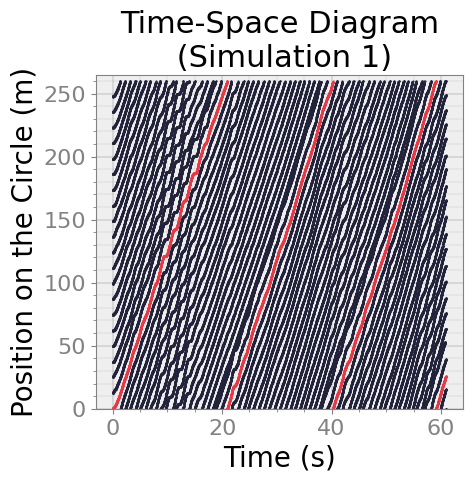

In [7]:
fig, ax = bagpy.create_fig(1)
fig.set_figwidth(4)
fig.set_figheight(4)
for i, df in enumerate(df_odom1):
    df = df.iloc[1600:-2000]
    if i == 0:
        ax[0].plot(df['Time'] - df['Time'].iloc[0], df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
              color = '#e63946')
    else:
        ax[0].plot(df['Time'] - df['Time'].iloc[0], df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
                  color = '#22223b')
    #ax[0].scatter(x = 'Time', y = 'distance', data = df, s= 1, label = C.name[i])
    
    
#ax[0].legend(fontsize = 20, ncol = 6, markerscale = 4)
ax[0].set_ylim(0, 265)
ax[0].set_xlabel('Time (s)', fontsize = 20)
ax[0].set_ylabel('Position on the Circle (m)', fontsize = 20)
ax[0].patch.set_facecolor('#efefef')
ax[0].set_title('Time-Space Diagram\n (Simulation 1)', fontsize = 22)
fig.savefig("timespace_fs.png", dpi = 100, bbox_inches='tight', transparent=False)
fig.savefig("timespace_fs.pdf", facecolor=(1,1,1,0), dpi = 40, bbox_inches='tight', transparent=False)
fig.show()
fig.show()


[INFO]  Data folder /home/ivory/CyverseData/ProjectSparkle/RTFvsNVehicles/sparkle_n_21_update_rate_30.0_max_update_rate_10.0_time_step_0.01_logtime_800.0_2020-10-31-15-23-20 already exists. Not creating.
No data on the topic:/tethys/odom
No data on the topic:/lapetus/odom
No data on the topic:/dione/odom
No data on the topic:/phoebe/odom
No data on the topic:/epimetheus/odom
No data on the topic:/hyperion/odom
No data on the topic:/rhea/odom
No data on the topic:/telesto/odom
No data on the topic:/deimos/odom
No data on the topic:/phobos/odom
No data on the topic:/triton/odom
No data on the topic:/proteus/odom
No data on the topic:/nereid/odom
No data on the topic:/larissa/odom
No data on the topic:/galatea/odom
No data on the topic:/despina/odom
No data on the topic:/sirius/odom
No data on the topic:/rigel/odom
No data on the topic:/vega/odom
No data on the topic:/altair/odom
No data on the topic:/capella/odom
No data on the topic:/alcor/odom
No data on the topic:/whirlpool/odom
No da

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


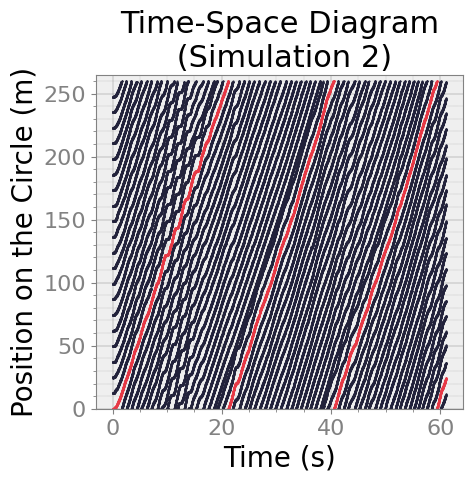

In [8]:
df_odom2 = []
b2 = bagreader(folder + '/' + bag2)
for nm in cars:
    setvelfile = b2.message_by_topic('/' + nm + '/odom')
    if setvelfile is None:
        continue
    setvel = pd.read_csv(setvelfile)
    df_odom2.append(setvel)
    
for i, df in enumerate(df_odom2):
    df['distance_per_step'] = 0
    distance_per_step = [C_init_straight[i]]
    df['distance'] = 0
    sum = C_init_straight[i]
    cum_sum = [C_init_straight[i]]
    for index, row in df.iloc[1:].iterrows():

        x = df['pose.pose.position.x'][index]
        y = df['pose.pose.position.y'][index]

        x_old = df['pose.pose.position.x'][index-1]
        y_old = df['pose.pose.position.y'][index-1]
        if np.abs(y) < 0.0001:
            y = 0
        if np.abs(x) < 0.0001:
            x = 0

        if np.abs(y_old) < 0.0001:
            y_old = 0
        if np.abs(x_old) < 0.0001:
            x_old = 0


        theta = math.atan2(y, x)
        theta_old = math.atan2(y_old, x_old)
        d_per_step = R*(np.abs(theta - theta_old))
        distance_per_step.append(d_per_step)
        sum = sum + d_per_step
        sum = sum%260
        cum_sum.append(sum)

    df['distance_per_step'] =distance_per_step
    df['distance'] = cum_sum
    
    
fig, ax = bagpy.create_fig(1)
fig.set_figwidth(4)
fig.set_figheight(4)
for i, df in enumerate(df_odom2):
    df = df.iloc[1600:-2000]
    if i == 0:
        ax[0].plot(df['Time'] - df['Time'].iloc[0], df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
              color = '#e63946')
    else:
        ax[0].plot(df['Time'] - df['Time'].iloc[0], df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
                  color = '#22223b')
    #ax[0].scatter(x = 'Time', y = 'distance', data = df, s= 1, label = C.name[i])
    
    
#ax[0].legend(fontsize = 20, ncol = 6, markerscale = 4)
ax[0].set_ylim(0, 265)
ax[0].set_xlabel('Time (s)', fontsize = 20)
ax[0].set_ylabel('Position on the Circle (m)', fontsize = 20)
ax[0].patch.set_facecolor('#efefef')
ax[0].set_title('Time-Space Diagram\n (Simulation 2)', fontsize = 22)
fig.savefig("timespace_fs_sim2.png", dpi = 100, bbox_inches='tight', transparent=False)
fig.savefig("timespace_fs_sim2.pdf", facecolor=(1,1,1,0), dpi = 40, bbox_inches='tight', transparent=False)
fig.show()
fig.show()


In [65]:
EA = []
for i in range(0, 21):
    df1= df_odom1[i]
    df2 = df_odom2[i]
    
    x1 = pd.DataFrame()
    y1 = pd.DataFrame()
    x1['Time'] = df1['Time'] - df1['Time'].iloc[0] +0.21
    x1['Message'] = df1['pose.pose.position.x']
    y1['Time'] = df1['Time'] - df1['Time'].iloc[0]+0.21
    y1['Message'] = df1['pose.pose.position.y']
    
    x2 = pd.DataFrame()
    y2 = pd.DataFrame()
    x2['Time'] = df2['Time'] - df2['Time'].iloc[0]
    x2['Message'] = df2['pose.pose.position.x']
    y2['Time'] = df2['Time'] - df2['Time'].iloc[0]
    y2['Message'] = df2['pose.pose.position.y']
    
    print(x1.shape, x2.shape)
    
   
    x1s, x2s = strymread.ts_sync(x1, x2, method='nearest', rate = 25)
    y1s, y2s = strymread.ts_sync(y1, y2, method='nearest', rate = 25)
    
    RMS = np.sqrt (  (x1s['Message']  - x2s['Message'])**2  + \
               (y1s['Message']  - y2s['Message'])**2  )

    E = np.sqrt(np.mean(RMS.values**2))
    EA.append(E)
    print(E)

(9691, 2) (9707, 2)
7.8376249188729865
(9690, 2) (9705, 2)
7.545185651809862
(9680, 2) (9705, 2)
7.885462817035745
(9692, 2) (9708, 2)
7.65224024559546
(9690, 2) (9706, 2)
7.972391003276165
(9689, 2) (9705, 2)
7.943865946373408
(9689, 2) (9705, 2)
7.726229598581215
(9692, 2) (9708, 2)
7.936310287025274
(9690, 2) (9706, 2)
7.680778540494065
(9691, 2) (9707, 2)
7.823044280642359
(9692, 2) (9708, 2)
7.9364358260369885
(9690, 2) (9706, 2)
7.772951711883833
(9692, 2) (9707, 2)
7.483594736714462
(9693, 2) (9709, 2)
7.769166290115752
(9692, 2) (9708, 2)
7.753410355082672
(9689, 2) (9705, 2)
7.603644523438943
(9691, 2) (9707, 2)
7.2411189213672715
(9690, 2) (9706, 2)
7.7666776071355
(9690, 2) (9706, 2)
7.7652937624222025
(9690, 2) (9706, 2)
7.606190992137462
(9689, 2) (9705, 2)
7.461388352654263


In [72]:
np.mean(EA)

7.722047922318852

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


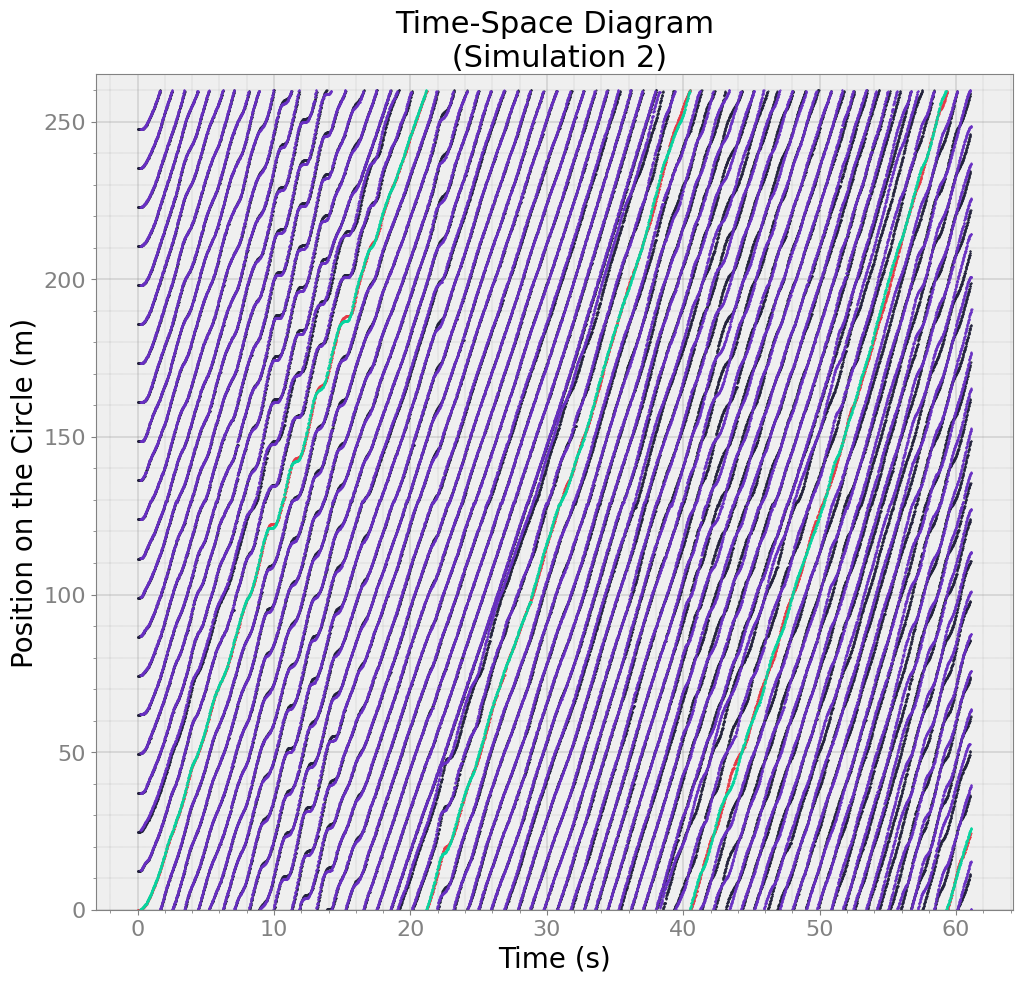

In [42]:
fig, ax = bagpy.create_fig(1)
fig.set_figwidth(10)
fig.set_figheight(10)
for i, df in enumerate(df_odom2):
    df = df.iloc[1600:-2000]
    if i == 0:
        ax[0].plot(df['Time'] - df['Time'].iloc[0], df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
              color = '#e63946')
    else:
        ax[0].plot(df['Time'] - df['Time'].iloc[0], df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
                  color = '#22223b')
    #ax[0].scatter(x = 'Time', y = 'distance', data = df, s= 1, label = C.name[i])
    
    
#ax[0].legend(fontsize = 20, ncol = 6, markerscale = 4)
# ax[0].set_ylim(0, 265)
# ax[0].set_xlabel('Time (s)', fontsize = 20)
# ax[0].set_ylabel('Position on the Circle (m)', fontsize = 20)
# ax[0].patch.set_facecolor('#efefef')
# ax[0].set_title('Time-Space Diagram\n (Simulation 2)', fontsize = 22)



for i, df in enumerate(df_odom1):
    df = df.iloc[1600:-2000]
    if i == 0:
        ax[0].plot(df['Time'] - df['Time'].iloc[0]+0.21, df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
              color = '#06d6a0')
    else:
        ax[0].plot(df['Time'] - df['Time'].iloc[0]+0.21, df['distance'], linewidth = 0, marker = '.', label = cars[i],markersize = 1, 
                  color = '#6930c3')
    #ax[0].scatter(x = 'Time', y = 'distance', data = df, s= 1, label = C.name[i])
    
    
#ax[0].legend(fontsize = 20, ncol = 6, markerscale = 4)
ax[0].set_ylim(0, 265)
ax[0].set_xlabel('Time (s)', fontsize = 20)
ax[0].set_ylabel('Position on the Circle (m)', fontsize = 20)
ax[0].patch.set_facecolor('#efefef')
ax[0].set_title('Time-Space Diagram\n (Simulation 2)', fontsize = 22)
fig.show()


In [49]:
EA = []
xtime1 = []
ytime1 =[]
xt1 = []
yt1 = []
xtime2 = []
ytime2 =[]
xt2 = []
yt2 = []
for i in range(0, 21):
    df1= df_odom1[i]
    df2 = df_odom2[i]
    
    x1 = pd.DataFrame()
    y1 = pd.DataFrame()
    x1['Time'] = df1['Time'] - df1['Time'].iloc[0] +0.21
    x1['Message'] = df1['pose.pose.position.x']
    y1['Time'] = df1['Time'] - df1['Time'].iloc[0]+0.21
    y1['Message'] = df1['pose.pose.position.y']
    
    x2 = pd.DataFrame()
    y2 = pd.DataFrame()
    x2['Time'] = df2['Time'] - df2['Time'].iloc[0]
    x2['Message'] = df2['pose.pose.position.x']
    y2['Time'] = df2['Time'] - df2['Time'].iloc[0]
    y2['Message'] = df2['pose.pose.position.y']
    
    xtime1= xtime1 + x1['Time'].tolist()
    ytime1 = ytime1 + y1['Time'].tolist()
    xt1 = xt1 + x1['Message'].tolist()
    yt1 = yt1 + y1['Message'].tolist()
    
    xtime2= xtime2 + x2['Time'].tolist()
    ytime2= ytime2 + y2['Time'].tolist()
    xt2 = xt2 + x2['Message'].tolist()
    yt2 = yt2 + y2['Message'].tolist()

In [55]:
len(xt1), len(xt2), len(xtime1), len(xtime2)

(203492, 203835, 203492, 203835)

In [56]:
len(yt1), len(yt2), len(ytime1), len(ytime2)

(203492, 203835, 203492, 203835)

In [57]:
xdf1 = pd.DataFrame()
xdf1['Time'] = xtime1
xdf1['Message'] = xt1

xdf2 = pd.DataFrame()
xdf2['Time'] = xtime2
xdf2['Message'] = xt2

ydf1 = pd.DataFrame()
ydf1['Time'] = ytime1
ydf1['Message'] = yt1

ydf2 = pd.DataFrame()
ydf2['Time'] = ytime2
ydf2['Message'] = yt2


In [60]:
xdf1 = xdf1.sort_values(by = 'Time')
ydf1 = ydf1.sort_values(by = 'Time')

xdf2 = xdf2.sort_values(by = 'Time')
ydf2 = ydf2.sort_values(by = 'Time')

In [61]:
xdf1s, xdf2s = strymread.ts_sync(xdf1, xdf2, method='nearest', rate = 25)
ydf1s, ydf2s = strymread.ts_sync(ydf1, ydf2, method='nearest', rate = 25)

In [67]:
xdf1s

,Time,Message
Clock,,
1970-01-01 00:00:00.210000000,0.210000,41.380300
1970-01-01 00:00:00.250024793,0.250025,-20.690116
1970-01-01 00:00:00.290049587,0.290050,-20.690116
1970-01-01 00:00:00.330074380,0.330074,39.541895
1970-01-01 00:00:00.370099174,0.370099,39.541895
1970-01-01 00:00:00.410123967,0.410124,34.190009
1970-01-01 00:00:00.450148760,0.450149,-9.207965
1970-01-01 00:00:00.490173554,0.490174,-9.207995
1970-01-01 00:00:00.530198347,0.530198,-30.333888
